In [1]:
%load_ext autoreload
%autoreload 2
# imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import trajectory_reconstruction_tradeoff as T
import random
import scanpy as sc
import warnings

warnings.filterwarnings('ignore')

random.seed(20)

/cs/labs/mornitzan/nomoriel/miniconda3/envs/traj2/lib/python3.8/site-packages/pyslingshot/slingshot.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# params
dirname = '../'
datadir = os.path.join(dirname, 'datasets' )
outdir = os.path.join(dirname, 'output')
save = False

# experiment params
dataset = 'fibroblasts'

cell_fit = 'log pc'
read_fit = 'log pt'
err_fit = 'l1'

read_title = lambda pt: r'$log(p_t)=$' + "{:.1f}".format(np.log(pt))
cell_title = lambda pc: r'$log(p_c)=$' + "{:.1f}".format(np.log(pc))
title = dataset

## Subsampling reconstruction error analysis
Prior to this notebook, run read, cell and tradeoff subsampling experiments with 'scripts/run.py'.
Here we plot and model the subsampling effect on the reconstruction error.

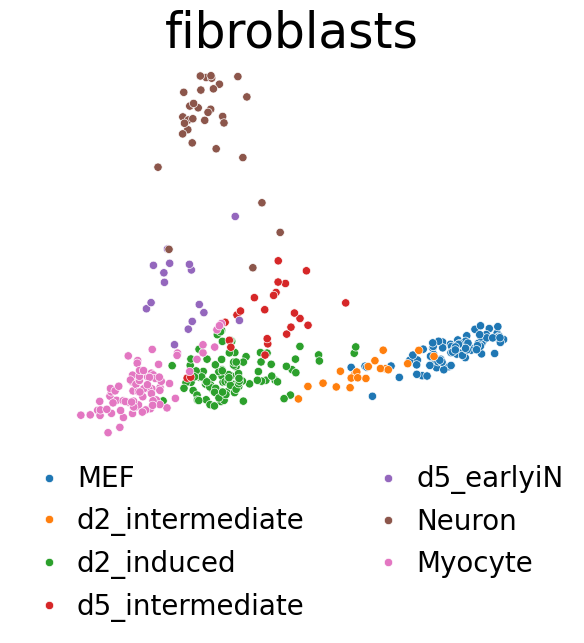

In [3]:
# read dataset
X, _, meta, milestone_network = T.io.read_dataset(dataset=dataset, dirname=datadir)
traj = T.tr.Trajectory(X, meta=meta, milestone_network=milestone_network)
palette = T.pl.generate_palette(traj)
T.pl.plot_project_pca2d(traj.pX, meta=traj.meta, title=title, legendsize=35, palette=palette)

### Read subsampling effect

Plotting reconstruction error as a function of read subsampling. 

The read reconstruction error, $\varepsilon_t$, is modeled as follows:
$$
\varepsilon_t \approx \begin{cases}
a + b \log{p_t} & \text{for } p_t < p_t^{sat} \\
\varepsilon_t^{sat} & \text{otherwise}
\end{cases} ,
$$

where $a, b$ are constants, $p_t^{sat}$ denotes the transition into a saturated sequencing regime where the reconstruction error, and $\varepsilon^{sat}_t$, is approximately constant.


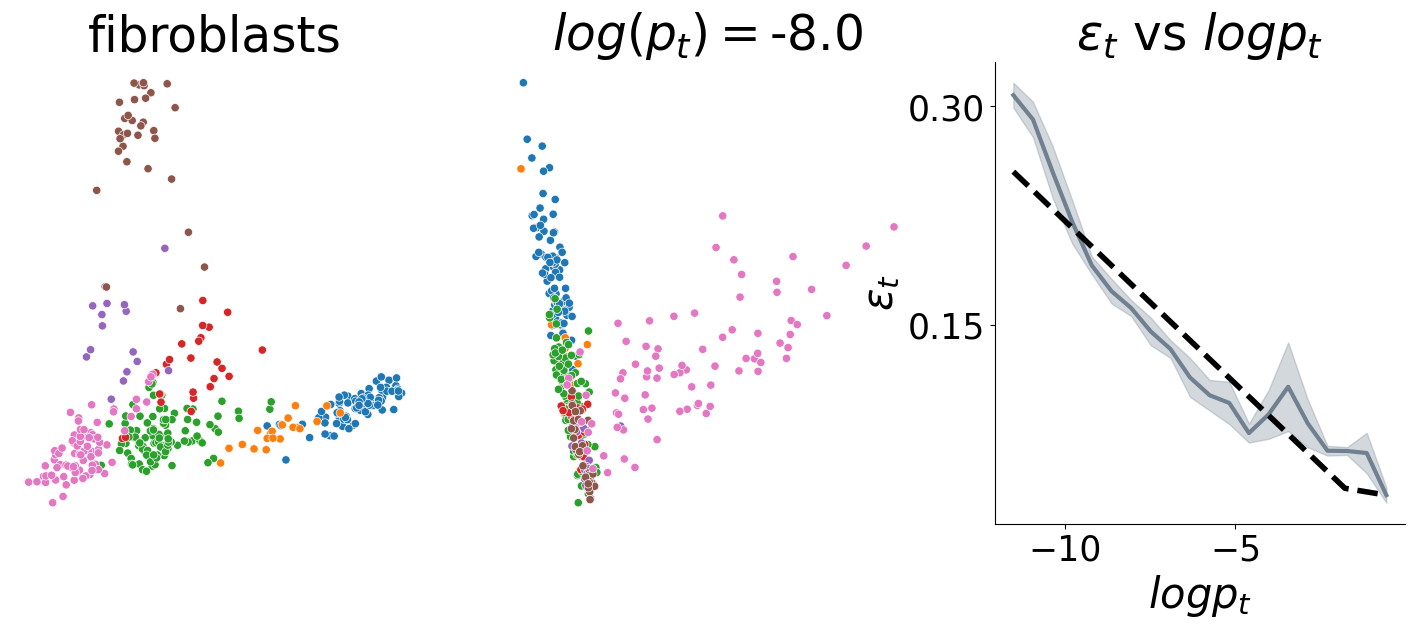

In [4]:
# plot read subsampling trend
L_read = T.io.read_output(dataset, outdir=outdir, sample='reads')

ncols =  3
nrows = 1
fig, ax = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))

# plotting true and an instance of subsampled trajectory
pt = np.exp(-8.0)
sX, psX, lsX, psD, sD, sn_neighbors, psP, ix, pca = traj.subsample(pc=1, pt=pt)
stitle = read_title(pt)
T.pl.plot_project_pca2d(traj.pX, meta=traj.meta, ax=ax[0], title=title, legend=False, palette=palette)
T.pl.plot_project_pca2d(psX, meta=traj.meta.loc[ix], ax=ax[1], title=stitle, legend=False, palette=palette)

# compute and plot read subsampling model
xcol = read_fit
xlabel = r'$log p_t$'
ycol = err_fit
ylabel = r'$\varepsilon_t$'
groupby = 'pt'
model_read = T.pl.plot_tradeoff(L_read, xcol=xcol, ycol=ycol, ylabel=ylabel, xlabel=xlabel, ax=ax[2], groupby=groupby, add_fit=True, model_type='saturation')

### Cell subsampling effect

The cell reconstruction error, $\varepsilon_c$, is fitted to the fraction of captured cells, $p_c$, by 
$$
\varepsilon_c \approx \alpha + \beta \log{p_c},
$$ 

where $\alpha$ and $\beta$ are constants.

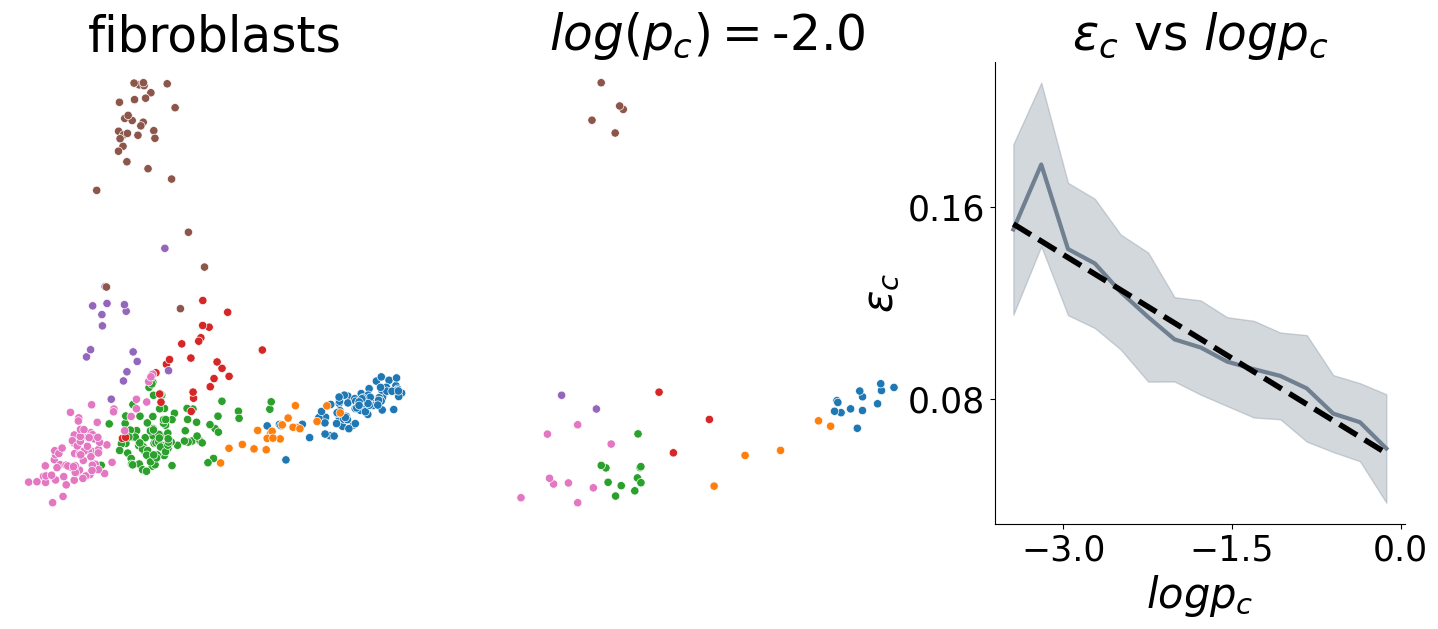

In [5]:
# plot cell subsampling trend
L_cell = T.io.read_output(dataset, outdir=outdir, sample='cells')

ncols =  3
nrows = 1
fig, ax = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6*nrows))

# plotting true and an instance of subsampled trajectory
pc = np.exp(-2.0)
sX, psX, lsX, psD, sD, sn_neighbors, psP, ix, pca = traj.subsample(pc=pc, pt=1)
T.pl.plot_project_pca2d(traj.pX, meta=traj.meta, ax=ax[0], title=title, legend=False, palette=palette)
T.pl.plot_project_pca2d(psX, meta=traj.meta.loc[ix], ax=ax[1], title=cell_title(pc), legend=False, palette=palette)

# compute and plot cell subsampling model
xcol = cell_fit
xlabel = r'$log p_c$'
ycol = err_fit
ylabel = r'$\varepsilon_c$'
groupby = 'pc'

model_cell = T.pl.plot_tradeoff(L_cell, xcol=xcol, ycol=ycol, ylabel=ylabel, xlabel=xlabel, ax=ax[2], groupby=groupby, add_fit=True)


### Tradeoff
Given a fixed sequencing budget, $B$, how can one minimize the reconstruction error? 
The inherent tradeoff between the number of cells and the number of reads per cell given a constant $B$ (where $B =  n_c \, n_r$) suggests that any shift in the balance between sequencing breadth and depth would lead to conflicting effects on the reconstruction error, as individually, the error increases with subsampling of both cells and reads. 



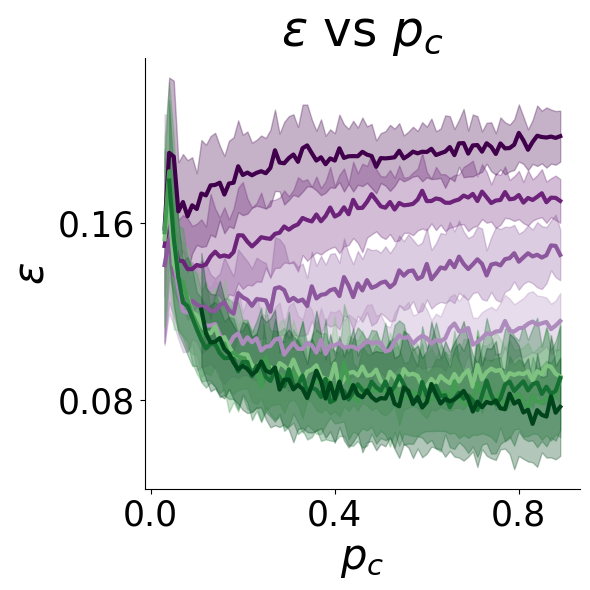

In [6]:
# read tradeoff experiments
L_tradeoff = T.io.read_output(dataset, outdir=outdir, sample='tradeoff')

xcol = 'pc'; 
min_B = 3e-5

# filtering experiments with too low budgets
L_tradeoff = L_tradeoff[L_tradeoff['B'] > min_B]

# filtering experiments with less than 20 reads per cell on average
# min_pt  = min_reads / traj.X.sum(1).mean()
# L_tradeoff = L_tradeoff[L_tradeoff['pt'] > min_pt]       
L_tradeoff['B'] = L_tradeoff['B'].apply(lambda x: round(x, 6))
Bs = L_tradeoff['B'].unique()


# set budget colors
nBs = len(Bs)
colors_by_budget = T.pl.get_colors_by_budget(Bs)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
T.pl.plot_tradeoff_experiments(L_tradeoff=L_tradeoff, plot_pc_opt=False, sharey=False, plot_pcs=False, xcol=xcol, 
                                colors=colors_by_budget, color_groupby='B', ycol=err_fit, ylabel=r'$\varepsilon$', xlabel=r'$p_c$', axs=ax)

# smoothing sampling results
roll = 4
L_tradeoff = T.opt.smooth_tradeoff(L_tradeoff, roll=roll)

if save:
    plt.savefig(os.path.join(outdir, 'tradeoff.png'))


#### Modeling reconstruction error
We model the overall reconstruction error as $\varepsilon=max(\varepsilon_c, \varepsilon_t)$. 

In [7]:
# predict curve from cell/read models
pred_cell_col = f'pred cell {err_fit}' 
pred_read_col = f'pred read {err_fit}'
pred_err_col = f'pred {err_fit}'
 
L_tradeoff[pred_cell_col] = model_cell.predict(L_tradeoff[[cell_fit]])
L_tradeoff[pred_read_col] = model_read.predict(L_tradeoff[[read_fit]])

L_tradeoff[pred_err_col] = np.maximum(L_tradeoff[pred_cell_col], L_tradeoff[pred_read_col])
    

#### Infering optimal sampling under tradeoff

To predict the optimal cell subsampling probability, $\hat{p_c}$, we solve $\varepsilon_c=\varepsilon_t$ for $p_c$. 

Given $\tilde{B}$, the fractional sequencing budget, and $p_c$, the cell subsampling probability, the respective cell reconstruction error is $\varepsilon_c = \alpha+\beta\log p_c$.


When sequencing is unsaturated ($p_t < p^{sat}_t$),the estimated read reconstruction error is
$\varepsilon_t =  a+b\log p_t =  a+b\log\frac{\tilde{B}}{p_c}$, and  $\hat{p_c} = \exp{ (\frac{a - \alpha + b \log{\tilde{B}}}{\beta + b})}$.

When sequencing is saturated ($p_t \geq p^{sat}_t$), sequencing at read subsampling probability $p^{sat}_t$  is optimal. 

Hence, altogether:


$$
\hat{p_c} \sim \begin{cases}
  \tilde{B}^\gamma & p_t < p_t^{sat} \\
  \tilde{B}/p_t^{sat} & \text{otherwise}
\end{cases} \nonumber ,
$$

with $\gamma=\frac{b}{\beta + b}$.

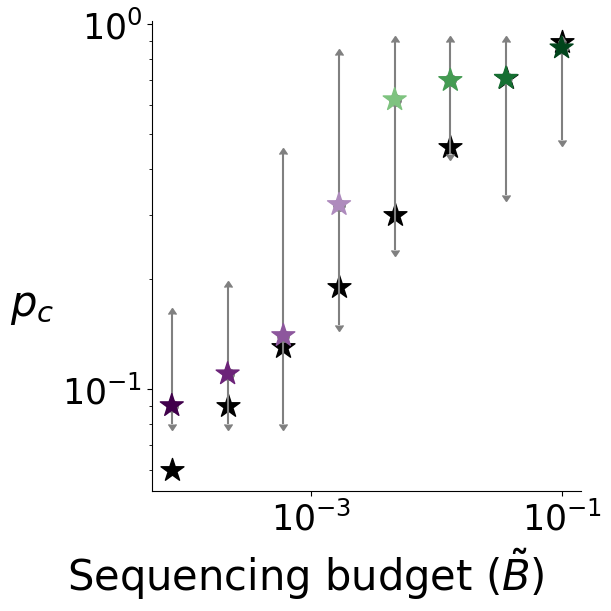

In [8]:
# compare predicted and true optimal sampling

xcol = 'pc'

# compute true optimal pc
emp_min = T.opt.compute_emp_min(L_tradeoff, err_fit=err_fit, groupby=xcol)

Bs_inrange = emp_min['B'].values

# compute minimum of predicted error
pc_min_pred = np.zeros_like(Bs_inrange)
for iB, B in enumerate(Bs_inrange):
    sL_tradeoff = L_tradeoff[L_tradeoff['B'] == B]
    pc_min_pred[iB] = sL_tradeoff.groupby(['pc']).mean()[pred_err_col].idxmin()

emp_min['pred pc'] = pc_min_pred


# plot optimal pc
limits = np.ones_like(Bs_inrange)
fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True)
ticksize = 25
labelsize = 30
ax.scatter(emp_min['B'], emp_min['pred '+ xcol], color='black', s=300, marker='*', zorder=0)

ax.errorbar(emp_min['B'], emp_min[xcol], yerr=emp_min[xcol + '_range_abv'],
        xlolims=limits, xuplims=limits, lolims=limits, 
        marker='o', markersize=8,
        linestyle='none', color='gray',zorder=5)
ax.errorbar(emp_min['B'], emp_min[xcol], yerr=emp_min[xcol + '_range_bel'],
        xlolims=limits, xuplims=limits, uplims=limits, 
        marker='o', markersize=8,
        linestyle='none', color='gray',zorder=5)

ax.scatter(emp_min['B'], emp_min[xcol], c=emp_min['B'].map(colors_by_budget), s=300, marker='*', zorder=10) 

ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='y', labelsize=ticksize)
ax.tick_params(axis='x', labelsize=ticksize)
ylabel = r'$p_c$'
xlabel = r'Sequencing budget ($\tilde{B}$)'
fig.supxlabel(xlabel, fontsize=labelsize)
fig.supylabel(ylabel, fontsize=labelsize, rotation=0)


if save:
    plt.savefig(os.path.join(outdir, 'optimal_pc.png'))